In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)

from nltk.corpus import stopwords
import nltk
import numpy as np
import re

In [2]:
df = pd.read_csv("../data/mtsamples.csv")
print(len(df))
df.head()

4999


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Because of the long tail, going to focus on top specialties only, say with >100 samples. Note there is a kind of inconsistent semantics here with visit types mixed in, we'll take a look at that in error analysis.

In [3]:
top_specialties = df.medical_specialty.value_counts()
top_specialties = top_specialties[top_specialties > 100]
top_specialties



medical_specialty
Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
Name: count, dtype: int64

In [6]:
classes = list(top_specialties.keys())
prev_count = len(df)
df = df.loc[df.medical_specialty.isin(classes)]
print(f"Went from {prev_count} samples to {len(df)} samples")

class_dict = {c:i for i, c in enumerate(classes)}

def one_hot_encode(specialty):
    y = np.zeros(len(classes), dtype=int)
    y[class_dict[specialty]] = 1
    return y

df["target"] = df.medical_specialty.apply(one_hot_encode)
df.head()

Went from 3923 samples to 3923 samples


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,target
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
11,11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [27]:
# train-val-test
# df["split"] = random.choices(
#     ["train", "val", "test"],
#     weights=[0.7, 0.15, 0.15],
#     k=len(df)
# )

# Create indices for train-test split
indices = np.arange(len(df))
np.random.shuffle(indices)  # Shuffle the indices

# Calculate split point (85% train, 15% test)
split_idx = int(0.85 * len(indices))
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

len(train_indices), len(test_indices)


(3334, 589)

# Pre-processing
- lower case
- remove punctuation and symbols
- remove stopwords

# Featurization
- BoW
- TF-IDF
- Embedding layer
- Pre-trained embedding

In [8]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    
    # Make sure stopwords are downloaded
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

df['processed_transcription'] = df['transcription'].apply(preprocess_text)

# Display a sample to verify the preprocessing
print("Original vs Processed example:")
sample_idx = 0
print("Original:", df['transcription'].iloc[sample_idx][:100], "...")
print("Processed:", df['processed_transcription'].iloc[sample_idx][:100], "...")
df.head()

Original vs Processed example:
Original: 2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size righ ...
Processed: 2d mmode 1 left atrial enlargement left atrial diameter 47 cm2 normal size right left ventricle3 nor ...


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,target,split,processed_transcription
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,2d mmode 1 left atrial enlargement left atrial...
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,1 left ventricular cavity size wall thickness ...
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,2d echocardiogrammultiple views heart great ve...
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,description1 normal cardiac chambers size2 nor...
11,11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",train,2d study1 mild aortic stenosis widely calcifie...


In [9]:
vocab = {}
for _, row in df.iterrows():
    x = row["processed_transcription"]
    for word in x.split():
        vocab[word] = vocab.get(word, 0) + 1
len(vocab)

42891

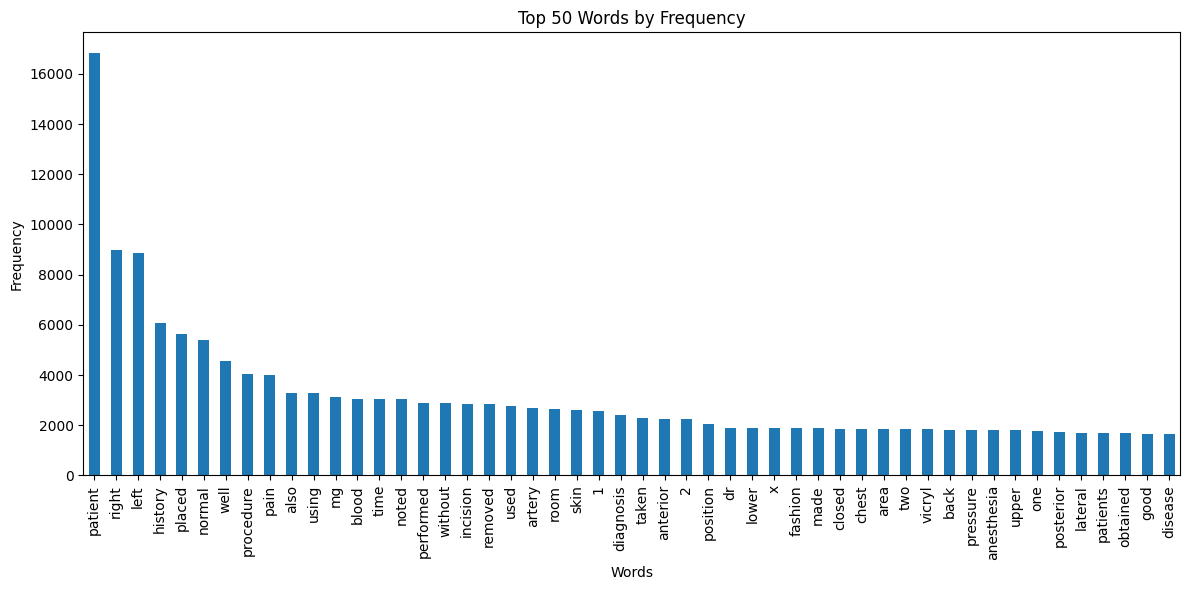

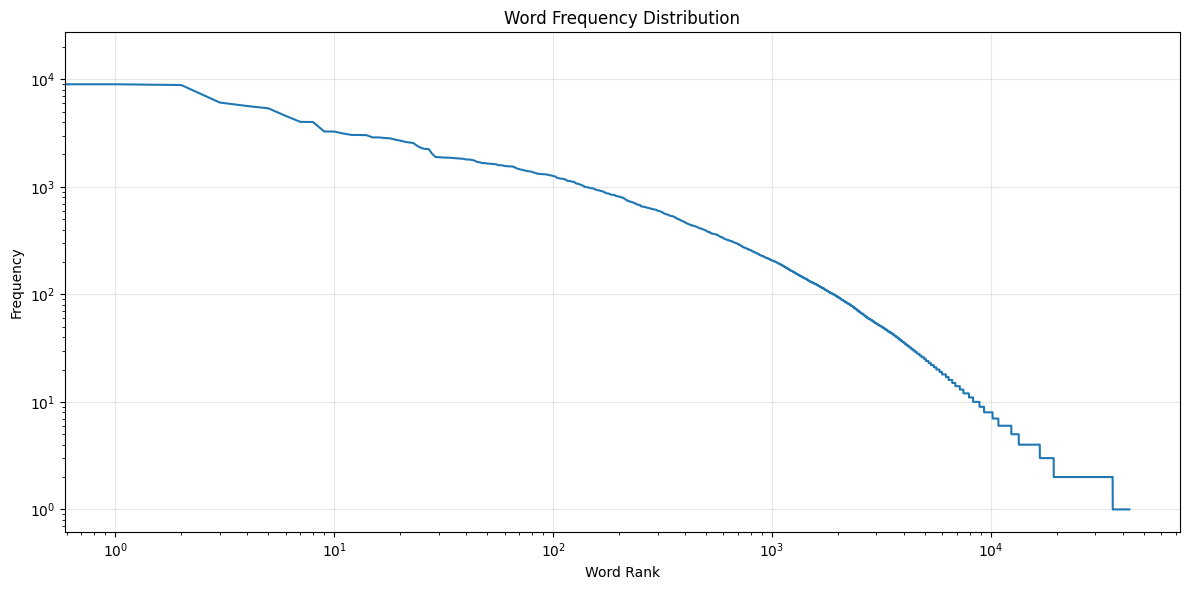

patient      16819
right         8995
left          8852
history       6085
placed        5646
normal        5376
well          4571
procedure     4022
pain          4006
also          3273
using         3268
mg            3133
blood         3041
time          3038
noted         3029
performed     2883
without       2881
incision      2846
removed       2826
used          2748
dtype: int64

In [10]:
# Convert vocab to a pandas Series for easier manipulation
word_counts = pd.Series(vocab)

# Sort by frequency (descending)
word_counts = word_counts.sort_values(ascending=False)

# Plot the distribution of the top 50 words
plt.figure(figsize=(12, 6))
word_counts.head(50).plot(kind='bar')
plt.title('Top 50 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot the overall distribution
plt.figure(figsize=(12, 6))
plt.plot(range(len(word_counts)), word_counts.values)
plt.title('Word Frequency Distribution')
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display the top 20 words
word_counts.head(20)

In [17]:
k = 10  
vocab_filtered = [word for word in vocab if vocab[word] > k]  # same order of magnitude as n
p = len(vocab_filtered)
p

8288

In [23]:
n = len(df)

X = np.zeros((n,p))
y = np.zeros((n,len(classes)))

from collections import Counter
def get_word_counts(s):
    freqs = Counter()
    for word in s.split():
        freqs[word] += 1
    return freqs

for i, row in df.iterrows():
    doc = row.processed_transcription
    freqs = get_word_counts(doc)
    x_bow = np.zeros(p)
    for j in range(p):
        word = vocab_filtered[j]
        x_bow[j] = freqs[word]
    X[i:] = x_bow
    y[i:] = row.target
X, y

# def get_bow_vector_binary(document):
#     return [1 if word in document else 0 for word in vocab_filtered]

# df["bow_binary"] = df.processed_transcription.apply(get_bow_vector_binary)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 3., 1., ..., 0., 0., 0.]], shape=(3923, 8288)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], shape=(3923, 12)))

In [19]:
# Calculate sparsity of X
# Sparsity is the percentage of zero elements in the matrix
sparsity = np.count_nonzero(X == 0) / X.size
print(f"Sparsity of X: {sparsity:.4f} ({sparsity*100:.2f}%)")

# Alternatively, we can calculate density (non-zero elements)
density = 1 - sparsity
print(f"Density of X: {density:.4f} ({density*100:.2f}%)")


Sparsity of X: 0.9806 (98.06%)
Density of X: 0.0194 (1.94%)


In [29]:
X[train_indices], y[train_indices]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 4., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.]], shape=(3334, 8288)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3334, 12)))

In [35]:
import torch
from torch.nn import Linear

class LogisticRegression(torch.nn.Module):
    def __init__(self, p, num_classes):
        super().__init__()
        self.linear = Linear(p, num_classes)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        return self.softmax(self.linear(x))

In [107]:
model = LogisticRegression(p, len(classes))
iterations = 1000
batch_size = 256
learning_rate = 0.1
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)

X_train_tensor = torch.FloatTensor(X[train_indices])
y_train_tensor = torch.LongTensor(y[train_indices].argmax(axis=1))
train_losses, val_losses = [], []

for i in range(iterations):
    # Sample a random batch
    indices = torch.randperm(len(X_train_tensor))[:batch_size]
    X_batch = X_train_tensor[indices]
    y_batch = y_train_tensor[indices]
    
    # Forward model on batch
    preds = model(X_batch)

    # Calculate loss
    loss = loss_function(preds, y_batch)

    # Backpropagate
    optimizer.zero_grad()
    loss.backward()

    # Take step
    optimizer.step()
    train_losses.append(loss.item())
    
    # Create a validation set (using a different random subset)
    val_indices = torch.randperm(len(X_train_tensor))[:batch_size*2]
    X_val = X_train_tensor[val_indices]
    y_val = y_train_tensor[val_indices]
    
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = loss_function(val_preds, y_val).item()
        val_losses.append(val_loss)

    if i % 10 == 0:
        print(f"Iteration {i}: Train loss: {loss.item():.4f}, Validation loss: {val_loss:.4f}")

Iteration 0: Train loss: 2.4843, Validation loss: 2.4705
Iteration 10: Train loss: 2.2252, Validation loss: 2.2295
Iteration 20: Train loss: 2.1585, Validation loss: 2.1544
Iteration 30: Train loss: 2.1257, Validation loss: 2.1062
Iteration 40: Train loss: 2.0754, Validation loss: 2.1342
Iteration 50: Train loss: 2.1042, Validation loss: 2.1145
Iteration 60: Train loss: 2.0777, Validation loss: 2.0655
Iteration 70: Train loss: 2.0509, Validation loss: 2.0893
Iteration 80: Train loss: 2.0895, Validation loss: 2.0340
Iteration 90: Train loss: 2.0651, Validation loss: 2.0340
Iteration 100: Train loss: 2.0570, Validation loss: 2.0379
Iteration 110: Train loss: 2.0053, Validation loss: 2.0099
Iteration 120: Train loss: 1.9991, Validation loss: 2.0371
Iteration 130: Train loss: 1.9591, Validation loss: 2.0232
Iteration 140: Train loss: 1.9820, Validation loss: 2.0276
Iteration 150: Train loss: 1.9914, Validation loss: 2.0199
Iteration 160: Train loss: 2.0030, Validation loss: 2.0040
Iteratio

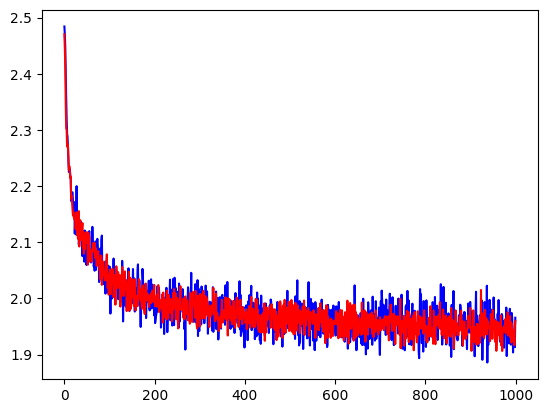

In [108]:
fig, ax = plt.subplots()
ax.plot(train_losses, color='blue')
ax.plot(val_losses, color='red')

In [109]:
X_test = torch.FloatTensor(X[test_indices])
y_test = torch.LongTensor(y[test_indices])

with torch.no_grad():
    y_pred = model(X_test)

_, predicted = torch.max(y_pred, dim=1)
_, true_labels = torch.max(y_test, dim=1)
accuracy = (predicted == true_labels).float().mean().item()
accuracy

0.6247877478599548